In [8]:
# %%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon, ttest_rel

NUM_PCS = 30
EN_PATHS = {
    "voom": f"01_simple_baselines/results/elastic_net/voom_{NUM_PCS}_pcs.csv",
    "log_tpm": f"01_simple_baselines/results/elastic_net/embeddings_{NUM_PCS}_pcs.csv",
}

def load_en(path, set_tag):
    df = pd.read_csv(path)
    df["Model"] = "ElasticNet"
    df["Set"] = set_tag  # 'voom' or 'log_tpm'
    # normalize columns
    df.rename(columns=lambda c: c.strip().replace("²", "^2"), inplace=True)
    if "r2_mean" not in df.columns and "r2_global" in df.columns:
        df = df.rename(columns={"r2_global": "r2_mean", "rmse": "rmse_mean"})
    keep = ["DRUG_ID","n_samples","r2_mean","rmse_mean","Model","Set"]
    missing = [c for c in keep if c not in df.columns]
    if missing:
        raise ValueError(f"Missing expected columns in {path}: {missing}")
    return df[keep]

feat_frames = [load_en(path, tag) for tag, path in EN_PATHS.items()]
en_df = pd.concat(feat_frames, ignore_index=True)
print("✅ combined:", en_df.shape)
en_df.head()


✅ combined: (1394, 6)


,DRUG_ID,n_samples,r2_mean,rmse_mean,Model,Set
0,1,391,0.031359,1.069695,ElasticNet,voom
1,3,356,0.033849,1.958721,ElasticNet,voom
2,5,394,0.137313,1.501935,ElasticNet,voom
3,6,403,-0.003588,0.884127,ElasticNet,voom
4,9,396,0.073031,1.406065,ElasticNet,voom


In [9]:
# %%
pretty_map = {"ElasticNet": "Elastic Net"}
set_map = {
    "voom": f"Voom ({NUM_PCS} PCs)",
    "log_tpm": f"Log-TPM ({NUM_PCS} PCs)"
}

df_plot = en_df.copy()
df_plot["ModelPretty"] = df_plot["Model"].map(pretty_map)
df_plot["SetPretty"] = df_plot["Set"].map(set_map)


In [10]:
# %% paired tests: VOOM vs LOG-TPM within Elastic Net (per DRUG_ID)
def paired_set_tests(df_model, metric="r2_mean"):
    wide = df_model.pivot_table(index="DRUG_ID", columns="Set", values=metric, aggfunc="mean").dropna()
    if wide.empty:
        return None
    # positive delta = VOOM better
    if metric == "r2_mean":
        d = wide["voom"] - wide["log_tpm"]
    else:  # RMSE: lower is better
        d = wide["log_tpm"] - wide["voom"]
    n = len(d)
    return {
        "n": n,
        "delta_mean": d.mean(),
        "delta_median": d.median(),
        "win_rate": (d > 0).mean(),  # fraction where VOOM wins
        "wilcoxon_p": wilcoxon(d, zero_method="pratt").pvalue if n >= 5 else np.nan,
        "ttest_p": ttest_rel(wide["voom"], wide["log_tpm"], nan_policy="omit").pvalue if n >= 5 else np.nan
    }

rows = []
df_m = en_df[en_df["Model"] == "ElasticNet"]
out_r2 = paired_set_tests(df_m, "r2_mean")
out_rmse = paired_set_tests(df_m, "rmse_mean")
if out_r2: rows.append({"Model":"ElasticNet","Metric":"R² (VOOM - LOG-TPM)",**out_r2})
if out_rmse: rows.append({"Model":"ElasticNet","Metric":"RMSE (LOG-TPM - VOOM)",**out_rmse})

en_summary = pd.DataFrame(rows)
display(en_summary)


,Model,Metric,n,delta_mean,delta_median,win_rate,wilcoxon_p,ttest_p
0,ElasticNet,R² (VOOM - LOG-TPM),697,0.040757,0.036982,0.906743,3.105098e-102,1.749529e-106
1,ElasticNet,RMSE (LOG-TPM - VOOM),697,0.032399,0.024744,0.913917,1.149630e-101,2.520297e-83


/tmp/ipykernel_2229376/2642787290.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([short_map.get(t.get_text(), t.get_text()) for t in ax.get_yticklabels()])


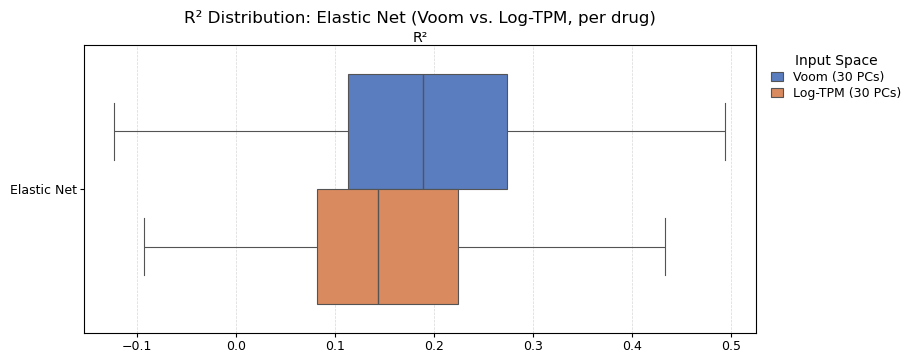

/tmp/ipykernel_2229376/2642787290.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([short_map.get(t.get_text(), t.get_text()) for t in ax.get_yticklabels()])


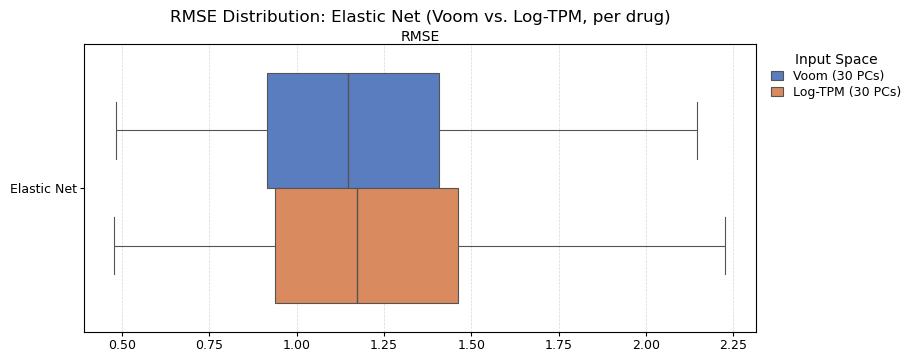

In [11]:
# %% helper for the slim, consistent styling
def nice_boxplot(df, x, title, xlabel_top):
    fig, ax = plt.subplots(figsize=(8, 3.6))
    sns.boxplot(
        data=df, x=x, y="ModelPretty",
        hue="SetPretty", palette="muted",
        showfliers=False, dodge=True, ax=ax,
        boxprops=dict(linewidth=0.8),
        whiskerprops=dict(linewidth=0.8),
        capprops=dict(linewidth=0.8),
        medianprops=dict(linewidth=1.0),
    )

    # shorten y labels (optional)
    short_map = {"Elastic Net": "Elastic Net"}
    ax.set_yticklabels([short_map.get(t.get_text(), t.get_text()) for t in ax.get_yticklabels()])
    ax.tick_params(axis="y", labelsize=10, pad=3)

    ax.set_title(title, fontsize=12)
    ax.xaxis.set_label_position('top' if xlabel_top else 'bottom')
    ax.set_xlabel("R²" if x=="r2_mean" else "RMSE", fontsize=10, labelpad=2)
    ax.set_ylabel("")

    ax.legend(
        title="Input Space", frameon=False, loc="upper left",
        bbox_to_anchor=(1.01, 1.0), fontsize=9, title_fontsize=10,
        handlelength=0.9, borderpad=0.2, labelspacing=0.25
    )

    for sp in ax.spines.values():
        sp.set_linewidth(0.8)
    ax.tick_params(axis="both", labelsize=9, width=0.8, length=3, pad=2)
    ax.grid(axis="x", linestyle="--", alpha=0.5, linewidth=0.5)

    plt.subplots_adjust(left=0.14, right=0.98, top=0.88, bottom=0.08)
    plt.show()

# --- R²
nice_boxplot(
    df=df_plot,
    x="r2_mean",
    title="R² Distribution: Elastic Net (Voom vs. Log-TPM, per drug)",
    xlabel_top=True
)

# --- RMSE
nice_boxplot(
    df=df_plot,
    x="rmse_mean",
    title="RMSE Distribution: Elastic Net (Voom vs. Log-TPM, per drug)",
    xlabel_top=True
)


In [12]:
# %% aggregate stats table
def agg_stats(df, metric):
    g = (
        df.groupby(["ModelPretty", "SetPretty"], as_index=False)[metric]
          .agg(mean="mean", std="std", n="count")
    )
    g["se"] = g["std"] / np.sqrt(g["n"])
    g["ci95"] = 1.96 * g["se"]
    g["metric"] = metric
    return g

stats_r2 = agg_stats(df_plot, "r2_mean")
stats_rmse = agg_stats(df_plot, "rmse_mean")
summary_table = pd.concat([stats_r2, stats_rmse], ignore_index=True).rename(
    columns={"mean":"Mean","std":"Std","n":"N","ci95":"95% CI"}
)
display(summary_table[["metric","ModelPretty","SetPretty","N","Mean","Std","95% CI"]].round(4))


,metric,ModelPretty,SetPretty,N,Mean,Std,95% CI
0,r2_mean,Elastic Net,Log-TPM (30 PCs),697,0.1545,0.0987,0.0073
1,r2_mean,Elastic Net,Voom (30 PCs),697,0.1953,0.1046,0.0078
2,rmse_mean,Elastic Net,Log-TPM (30 PCs),697,1.2225,0.3737,0.0277
3,rmse_mean,Elastic Net,Voom (30 PCs),697,1.1901,0.3607,0.0268
